# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [6]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

In [37]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
import numpy as np
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from ipywidgets import interact
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance

In [8]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [9]:
    def el(v):
        if isinstance(v, float) or v[0] == '<':
            return 0
        return  int(v[0:(1 if v[1] == '.' else 2)])

In [10]:
train['violation'] = train.Violations.apply(el)

In [11]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail,violation
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,3
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,32
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,35
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,38
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,34


In [12]:
train['Facility Type'].unique()

array(['Restaurant', 'Grocery Store', 'School', 'Long Term Care',
       'Liquor', 'Daycare Above and Under 2 Years',
       "Children's Services Facility", 'Catering', 'Daycare Night',
       'CHURCH', 'GAS STATION/STORE', 'Daycare (2 - 6 Years)',
       'Mobile Food Preparer', 'Golden Diner', 'TAVERN', 'ICE CREAM SHOP',
       'Banquet Hall', 'coffee shop', 'Bakery',
       'SLAUGHTER HOUSE/ GROCERY', 'RESTAURANT/GROCERY STORE',
       'Shared Kitchen User (Long Term)', 'Daycare (Under 2 Years)',
       'Wholesale', 'Mobile Food Dispenser', nan, 'Daycare Combo 1586',
       'Hospital', 'STORE', 'Airport Lounge', 'LIVE POULTRY', 'tavern',
       'REPACKAGING PLANT', 'Daycare (2 Years)',
       'Mobile Prepared Food Vendor', 'CHURCH KITCHEN',
       'GROCERY/GAS STATION', 'GAS STATION STORE', 'BAR',
       'Navy Pier Kiosk', 'STADIUM', 'Special Event', 'KIOSK',
       'RETAIL STORE', 'CATERING/CAFE', 'GROCERY/RESTAURANT',
       'MOVIE THEATRE', 'Shared Kitchen', 'DAYCARE', 'TEA BREWIN

In [13]:
train.City.unique()

array(['CHICAGO', nan, 'LAKE BLUFF', 'BEDFORD PARK', 'chicago', 'MAYWOOD',
       'CCHICAGO', 'SUMMIT', 'Chicago', 'CHicago', 'SCHAUMBURG',
       'CHESTNUT STREET', 'ELK GROVE VILLAGE', 'OOLYMPIA FIELDS',
       'CHICAGO HEIGHTS', 'NILES NILES', 'EVANSTON', 'CHCHICAGO',
       'OAK PARK', 'CICERO', 'NAPERVILLE', 'EAST HAZEL CREST', 'BERWYN',
       'SKOKIE', 'CHARLES A HAYES', 'WORTH', 'HIGHLAND PARK', 'ROSEMONT',
       'BOLINGBROOK', 'TINLEY PARK', 'SCHILLER PARK', 'ELMHURST',
       'CHICAGOI', 'BRIDGEVIEW', 'BROADVIEW', 'OLYMPIA FIELDS',
       'CHICAGOCHICAGO', 'CHICAGOHICAGO', 'STREAMWOOD', 'ALSIP'],
      dtype=object)

In [14]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
violation            int64
dtype: object

In [15]:
ftypes = ['Restaurant', 'Grocery', 'Liquor', 'gas station', 'hospital', 'movie', 'mobile',
          'cafeteria', 'school' ]

In [16]:
def wrangle(X, make_means=False):
    X = X.copy()
    
    def el(v):
        if isinstance(v, float) or v[0] == '<':
            return 0
        return  int(v[0:(1 if v[1] == '.' else 2)]) 
    
    X['violation'] = X.Violations.apply(el)
    X = X.drop(columns=['Violations', 'Inspection ID', 'AKA Name', 'License #', 'State'])
    
    def er(r):
        if isinstance(r, float):
            return 0
        return int(r[5:6 if r[6] == ' ' else 7])
    X['risk'] = X.Risk.apply(er)
    X = X.drop(columns='Risk')
        
    def wrangle_list(x, l):
        if isinstance(x, float):
            return False
        x = x.lower()
        for s in l:
            if x.find(s) >= 0:
                return s
        return False
    
    X['ftype'] = X['Facility Type'].apply(lambda x: wrangle_list(x, ftypes))
    
    def wrangle_chicago(x):
        if isinstance(x, float):
            return 'chicago'  
        x = x.lower()
        if 'chicago' in x:
            return 'chicago'
        return x
    
    X['city'] = X.City.apply(wrangle_chicago)
    X = X.drop(columns=['Facility Type', 'City'])
    return X 
        

In [17]:
df = wrangle(train)

In [18]:
y = df.Fail
df_ = df.drop(columns='Fail')

In [19]:
clist = df_.select_dtypes(exclude=[np.number]).columns.tolist()

In [20]:
one_hot_columns = []
binary_columns = []
max_one = 15
for c in  clist:
    if len(df_[c].unique()) > max_one:
        binary_columns.append(c)
    else:
        one_hot_columns.append(c)

In [21]:
pipe = Pipeline(steps = [
    ('be', ce.BinaryEncoder(cols=binary_columns)), 
    ('one', ce.OneHotEncoder(use_cat_names=True,cols=one_hot_columns)),
#     ('pca', pca),
    ('xgb', XGBClassifier())]
)

In [55]:
param_grid = {
    #     'pca__n_components': [28],
    "xgb__booster": ["gbtree"],
    "xgb__gamma": [8,9,10],
    "xgb__learning_rate": [0.1],
    "xgb__n_estimators": [130],
    #     "gb__min_samples_leaf": [3],
    #     "gb__min_impurity_decrease": [1.2],
    "xgb__max_depth": [3,4]
}
# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1,
                  scoring='roc_auc',
                  verbose=1)

In [57]:
gsf = gs.fit(df_, y)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   22.4s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   24.4s finished


In [86]:
print('Best Parameter (roc_auc score=%0.3f):' % gsf.best_score_)
print(gsf.best_params_)

Best Parameter (roc_auc score=0.989):
{'xgb__booster': 'gbtree', 'xgb__gamma': 9, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 130}


In [104]:
pyt = gsf.predict(df_)
len(pyt),len(y),len(dff_)

(51916, 51916, 51916)

In [87]:
test_y = test['Fail'].values
testxy = test.drop(columns='Fail')

In [88]:
test_ = wrangle(testxy)

In [89]:
py = gsf.predict(test_)

In [90]:
roc_auc_score(test_y,py)

0.9393951363427173

In [91]:
 xgb =  gsf.best_estimator_.named_steps['xgb']
#     gsf.best_estimator_

In [92]:
xgb.feature_importances_

array([0.0056101 , 0.00701262, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00140252,
       0.        , 0.        , 0.00140252, 0.00280505, 0.00280505,
       0.00140252, 0.        , 0.        , 0.        , 0.00140252,
       0.        , 0.        , 0.00140252, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00140252, 0.        , 0.        , 0.        ,
       0.00140252, 0.        , 0.        , 0.00140252, 0.        ,
       0.00140252, 0.        , 0.        , 0.        , 0.00140252,
       0.00280505, 0.        , 0.        , 0.        , 0.        ,
       0.00701262, 0.00280505, 0.        , 0.01402525, 0.01542777,
       0.11781206, 0.14025246, 0.14446002, 0.05750351, 0.        ,
       0.        , 0.00280505, 0.00280505, 0.        , 0.        ,
       0.00140252, 0.00140252, 0.00420757, 0.        , 0.        ,
       0.        , 0.        , 0.0056101 , 0.        , 0.     

In [66]:
from matplotlib import pyplot as plt

In [67]:
%matplotlib inline

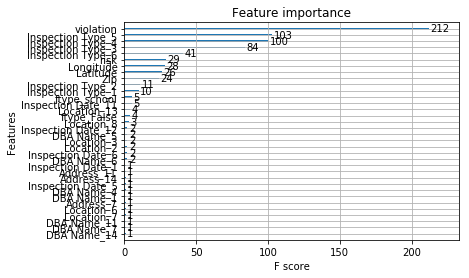

In [80]:
plot_importance(xgb)

In [44]:
encoders = Pipeline([
                ('binary', ce.BinaryEncoder(cols=binary_columns)),
                ('onehot', ce.OneHotEncoder(use_cat_names=True,cols=one_hot_columns))
#                 ('DecisionTree', DecisionTreeClassifier(max_depth=17, class_weight='balanced'))
            ])
dff = encoders.fit(df)
dff_ = dff.transform(df)

In [99]:
len(dff_)

51916

In [46]:
gsf.best_estimator_.steps[-1][-1].feature_importances

AttributeError: 'XGBClassifier' object has no attribute 'feature_importances'

In [107]:
def partial_dependency(bst, X, y, y_pred, feature):
    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()
    
    grid = np.linspace(start=np.percentile(X_temp[feature], 0.1),
                       stop=np.percentile(X_temp[feature], 99.5),
                       num=len(y))
    

    plt.plot(grid, y_pred, '-', color='red', linewidth=2.5)
    plt.plot(X, y, 'o', color='grey', alpha=0.01)
    plt.xlim(min(grid), max(grid))
    plt.xlabel(feature)
    plt.ylabel(y.name)
    plt.show()

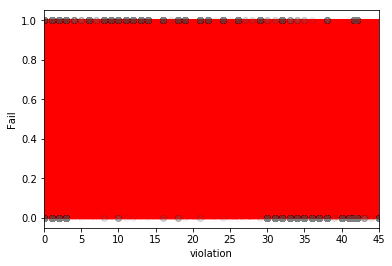

In [108]:
partial_dependency(gsf,dff_, y, pyt, 'violation')

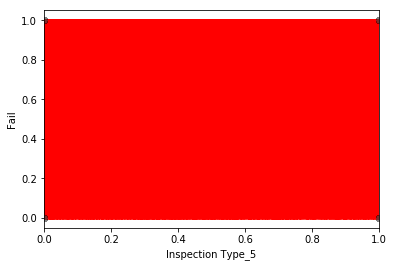

In [114]:
partial_dependency(gsf,dff_, y, pyt, 'Inspection Type_5')

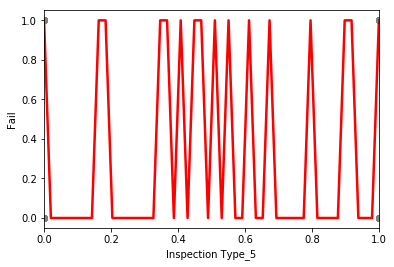

In [115]:
partial_dependency(gsf,dff_[0:50], y[0:50], pyt[0:50], 'Inspection Type_5')

In [112]:
dftt = pd.DataFrame(dff_.columns)

In [113]:
dftt

,0
0,ftype_False
1,ftype_school
2,ftype_gas station
3,ftype_mobile
4,ftype_hospital
5,ftype_movie
6,ftype_cafeteria
7,ftype_-1
8,DBA Name_0
9,DBA Name_1
